In [17]:
# Import statements
import numpy as numpy
import pandas as pd
import seaborn as sns #for plotting
import matplotlib.pyplot as plt
import random

In [18]:
# Define datasets for individual inhibitory checkpoints
data = pd.read_csv('data/ab_ag.tsv', sep='\t')
pd1 = data[data['compound'].str.contains('PD-1', na=False)]
pdl1 = data[data['compound'].str.contains('PD-L1', na=False)]
ctla4 = data[data['compound'].str.contains('CTLA-4', na=False)]
kir = data[data['compound'].str.contains('KIR', na=False)]
lag3 = data[data['compound'].str.contains('LAG', na=False)]
tim3 = data[data['compound'].str.contains('TIM3', na=False)]

In [19]:
# Filter out necessary columns
pd1 = pd1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
pdl1 = pdl1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
ctla4 = ctla4[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
kir = kir[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
lag3 = lag3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
tim3 = tim3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]

In [20]:
combined_dataset = [pdl1, pd1, ctla4, kir, lag3, tim3]

# Shuffle the list randomly
random.shuffle(combined_dataset)

# Concatenate them in the new random order
merged_df = pd.concat(combined_dataset, ignore_index=True)
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)

In [21]:
shuffled_df = shuffled_df[shuffled_df['resolution'] < 3.5]
shuffled_df = shuffled_df.dropna()

In [22]:
l = ['CTLA-4', 'TIM3', 'PD-1', 'PD-L1', 'KIR', 'LAG3']

new_df = pd.DataFrame(index = l)

for item in l:
    count = shuffled_df[shuffled_df['compound'].str.contains(item, na=False)].shape[0]
    new_df.loc[item, 'count'] = count

new_df = new_df.reset_index()
new_df.columns = ['checkpoint', 'count'] 

In [23]:
# 1. Filter all relevant rows: those with 'mab' OR 'M6903'
ab_mask = shuffled_df['compound'].str.contains('mab|M6903', na=False, case=False)
shuffled_df_ab = shuffled_df[ab_mask]

# 2. Extract antibody names
shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)

# 3. Fill in M6903 manually where missing
m6903_mask = shuffled_df_ab['compound'].str.contains('M6903', na=False)
shuffled_df_ab.loc[m6903_mask, 'antibody'] = shuffled_df_ab.loc[m6903_mask, 'antibody'].fillna('M6903')

# # 4. Extract checkpoint names
checkpoints_pattern = r'\b(PD-1|PD-L1|CTLA-4|KIR2DL3|TIM3)\b'
shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)

# # 5. Final formatting
shuffled_df_ab = shuffled_df_ab[['antibody', 'checkpoint', 'pdb', 'Hchain', 'Lchain', 'antigen_chain']]
shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

shuffled_df_ab


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2002865464.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)
/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2002865464.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)


,antibody,checkpoint,pdb,Hchain,Lchain,antigen_chain
0,M6903,TIM3,6txz,K,O,D
1,IPILIMUMAB,CTLA-4,5tru,h,l,c
2,PEMBROLIZUMAB,PD-1,5b8c,K,J,L
5,ATEZOLIZUMAB,PD-L1,5x8l,G,L,B
7,IPILIMUMAB,CTLA-4,7su1,H,L,C
8,IPILIMUMAB,CTLA-4,9dq4,H,L,A
9,SASANLIMAB,PD-1,6xkr,H,L,P
10,DURVALUMAB,PD-L1,5xj4,H,L,A
12,IPILIMUMAB,CTLA-4,7su0,H,L,C
13,CEMIPLIMAB,PD-1,7wvm,A,B,E


In [24]:
pdb_list = shuffled_df_ab['pdb'].unique().tolist()
#shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

with open('pdb_list.txt', 'w') as f:
    for pdb in pdb_list:
        f.write(pdb + '\n')

In [25]:
# make a list of the columns 
shuffled_df_ab = shuffled_df_ab[['pdb', 'Hchain', 'Lchain', 'antigen_chain']]
extracted_list = shuffled_df_ab.values.tolist()

extracted_list


[['6txz', 'K', 'O', 'D'],
 ['5tru', 'h', 'l', 'c'],
 ['5b8c', 'K', 'J', 'L'],
 ['5x8l', 'G', 'L', 'B'],
 ['7su1', 'H', 'L', 'C'],
 ['9dq4', 'H', 'L', 'A'],
 ['6xkr', 'H', 'L', 'P'],
 ['5xj4', 'H', 'L', 'A'],
 ['7su0', 'H', 'L', 'C'],
 ['7wvm', 'A', 'B', 'E'],
 ['6txz', 'I', 'M', 'B'],
 ['5xj3', 'D', 'E', 'F'],
 ['7bxa', 'H', 'L', 'P'],
 ['9dq3', 'H', 'L', 'C'],
 ['5jxe', 'D', 'C', 'B'],
 ['7cgw', 'H', 'L', 'P'],
 ['6rp8', 'h', 'l', 'c'],
 ['5x8l', 'J', 'O', 'E'],
 ['5ggs', 'A', 'B', 'Z'],
 ['5b8c', 'B', 'A', 'C'],
 ['5x8l', 'F', 'K', 'A'],
 ['5wt9', 'H', 'L', 'G'],
 ['8gy5', 'A', 'B', 'Q'],
 ['5xj3', 'A', 'B', 'C'],
 ['7cgw', 'A', 'B', 'C'],
 ['7cu5', 'A', 'A', 'Q'],
 ['5b8c', 'H', 'G', 'I'],
 ['5x8l', 'S', 'N', 'D'],
 ['5ggr', 'H', 'L', 'Z'],
 ['5jxe', 'G', 'F', 'A'],
 ['5b8c', 'E', 'D', 'F'],
 ['7cu5', 'B', 'B', 'E'],
 ['8tui', 'H', 'L', 'A'],
 ['5xxy', 'H', 'L', 'A'],
 ['7su0', 'I', 'M', 'D'],
 ['6txz', 'J', 'N', 'C'],
 ['7bxa', 'B', 'C', 'A'],
 ['8gy5', 'H', 'L', 'P'],
 ['5ggs', 'C

# Paratope, Hydrogen-Bonds, Saltbridges

In [26]:
import os
from pymol import cmd
import pandas as pd

results = []

# input 
root_folder = "structures"
cutoff_distance = 5.0  # in Å distance
hbond_cutoff = 3.5  # in Å distance for hydrogen bonds
salt_cutoff = 4.0  # in Å distance for salt bridges

# Ensure extracted_list is defined
if 'extracted_list' not in locals():
    extracted_list = []  # Replace with actual data if available

# Your extracted list from your DataFrame Format: [pdb_id, H_chain, L_chain, antigen_chain]

# Loop over each chain combination from the extracted list
for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue
    else:
        print(f"Processing {pdb_id}...")

        cmd.reinitialize()
        cmd.load(pdb_path)

        # Selections
        cmd.select("antibody", f"chain {h_chain}+{l_chain}")
        cmd.select("antigen", f"chain {ag_chain}")
        cmd.select("paratope", f"antibody within {cutoff_distance} of antigen")

        # Color antibody chains 
        cmd.color("marine", f"chain {h_chain}")
        cmd.color("skyblue", f"chain {l_chain}")

        # Color antigen chain (e.g., salmon)
        cmd.color("salmon", "antigen")

        # Optional: highlight paratope (already near antigen)
        cmd.color("yellow", "paratope")

        # Surface area
        paratope_area = cmd.get_area("paratope")
        print(f"   ➤ Epitope surface area: {paratope_area:.2f} Å²")

        # Hydrogen bonds
        hbonds = cmd.find_pairs("antibody", "antigen", mode=1, cutoff=hbond_cutoff)
        num_hbonds = len(hbonds)
        print(f"Found {num_hbonds} hydrogen bonds at the interface.")

        # salt bridges 
        # 1) antibody acidic O  → antigen basic N
        cmd.select("acidic_ab", f"chain {h_chain}+{l_chain} and resn ASP+GLU "
                                "and name OD1+OD2+OE1+OE2")
        cmd.select("basic_ag",  f"chain {ag_chain} and resn LYS+ARG+HIS "
                                "and name NZ+NH1+NH2+ND1+NE2")
        sb1 = cmd.find_pairs("acidic_ab", "basic_ag", cutoff=salt_cutoff, mode=1)

        # 2) antigen acidic O → antibody basic N
        cmd.select("acidic_ag", f"chain {ag_chain} and resn ASP+GLU "
                                "and name OD1+OD2+OE1+OE2")
        cmd.select("basic_ab",  f"chain {h_chain}+{l_chain} and resn LYS+ARG+HIS "
                                "and name NZ+NH1+NH2+ND1+NE2")
        sb2 = cmd.find_pairs("acidic_ag", "basic_ab", cutoff=salt_cutoff, mode=1)

        # cleanup salt-bridge selections
        for sel in ("acidic_ab","basic_ag","acidic_ag","basic_ab"):
            cmd.delete(sel)

        num_salt_bridges = len(sb1) + len(sb2)
        print(f"   ➤ Salt bridges: {num_salt_bridges}")

        # save session (optional) 
        session_out = os.path.join(dirpath, f"{pdb_id}paratope.pse")
        cmd.save(session_out)

        # collect results 
        results.append({
            "pdb_id":              pdb_id,
            "H_chain":             h_chain,
            "L_chain":             l_chain,
            "antigen_chain":       ag_chain,
            "paratope_area":       paratope_area,
            "num_hydrogen_bonds":  num_hbonds,
            "num_salt_bridges":    num_salt_bridges,
            "folder":              os.path.basename(dirpath)
        })

# Save to CSV
df = pd.DataFrame(results)
# Remove duplicate block
# Save results to CSV 
df = pd.DataFrame(results)
df.to_csv("paratope_surface_hbonds_summary.csv", index=False)

print("All done. Results saved to 'paratope_surface_hbonds_summary.csv'")

Processing 6txz...
   ➤ Epitope surface area: 1725.09 Å²
Found 28 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5tru...
   ➤ Epitope surface area: 1292.96 Å²
Found 17 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5b8c...
   ➤ Epitope surface area: 1955.86 Å²
Found 29 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5x8l...
   ➤ Epitope surface area: 1517.16 Å²
Found 26 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 7su1...
   ➤ Epitope surface area: 1082.11 Å²
Found 14 hydrogen bonds at the interface.
   ➤ Salt bridges: 2
Processing 9dq4...
   ➤ Epitope surface area: 1897.17 Å²
Found 212 hydrogen bonds at the interface.
   ➤ Salt bridges: 3
Processing 6xkr...
   ➤ Epitope surface area: 1791.78 Å²
Found 20 hydrogen bonds at the interface.
   ➤ Salt bridges: 1
Processing 5xj4...
   ➤ Epitope surface area: 1421.13 Å²
Found 26 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 7su0...
   ➤ Epitope surface

In [27]:
import pandas as pd

df = pd.read_csv("paratope_surface_hbonds_summary.csv")
print(df['pdb_id'].value_counts())

pdb_id
5x8l    5
6txz    4
5b8c    4
5xj3    4
5jxe    2
5ggr    2
7cu5    2
8gy5    2
5ggs    2
6rp8    2
5tru    2
7cgw    2
7bxa    2
7wvm    2
7su0    2
9dq3    1
5xj4    1
5wt9    1
6xkr    1
9dq4    1
7su1    1
8tui    1
5xxy    1
5grj    1
7wsl    1
6k0y    1
5ggv    1
5x8m    1
Name: count, dtype: int64


## Plotting the results 

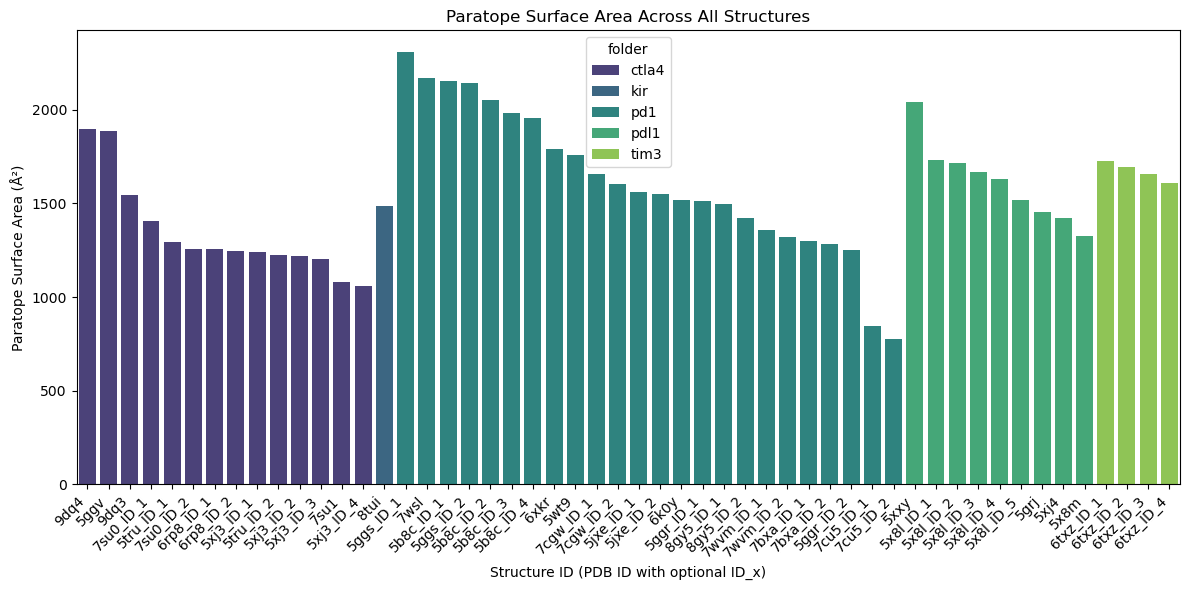

In [28]:
from collections import defaultdict, Counter 

# Sort as before
df_sorted = df.sort_values(by=["folder", "paratope_area"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted["structure_id"] = structure_ids

# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y="paratope_area", hue="folder", dodge=False, palette="viridis")

plt.title("Paratope Surface Area Across All Structures")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Paratope Surface Area (Å²)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('plots/paratopee_surface_area_across_all_structures.pdf', bbox_inches='tight')
plt.show()



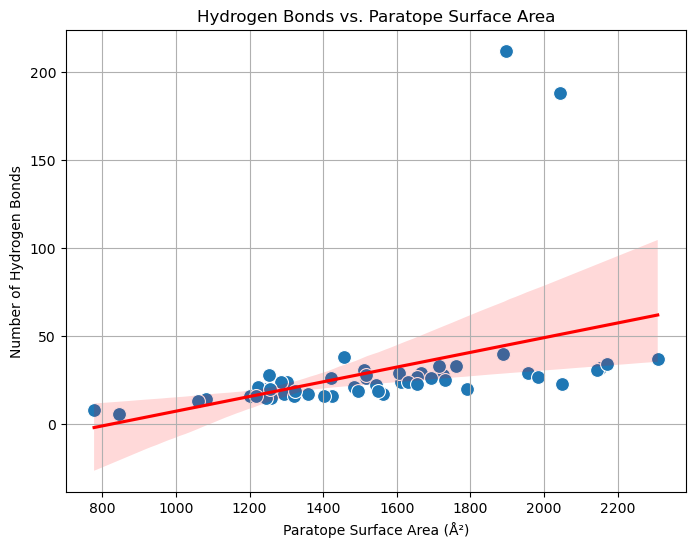

In [29]:
df = pd.read_csv("paratope_surface_hbonds_summary.csv")

# Scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="paratope_area", y="num_hydrogen_bonds", s=100)
sns.regplot(data=df, x="paratope_area", y="num_hydrogen_bonds", scatter=False, color="red")
plt.xlabel("Paratope Surface Area (Å²)")
plt.ylabel("Number of Hydrogen Bonds")
plt.title("Hydrogen Bonds vs. Paratope Surface Area")
plt.grid(True)
plt.show()

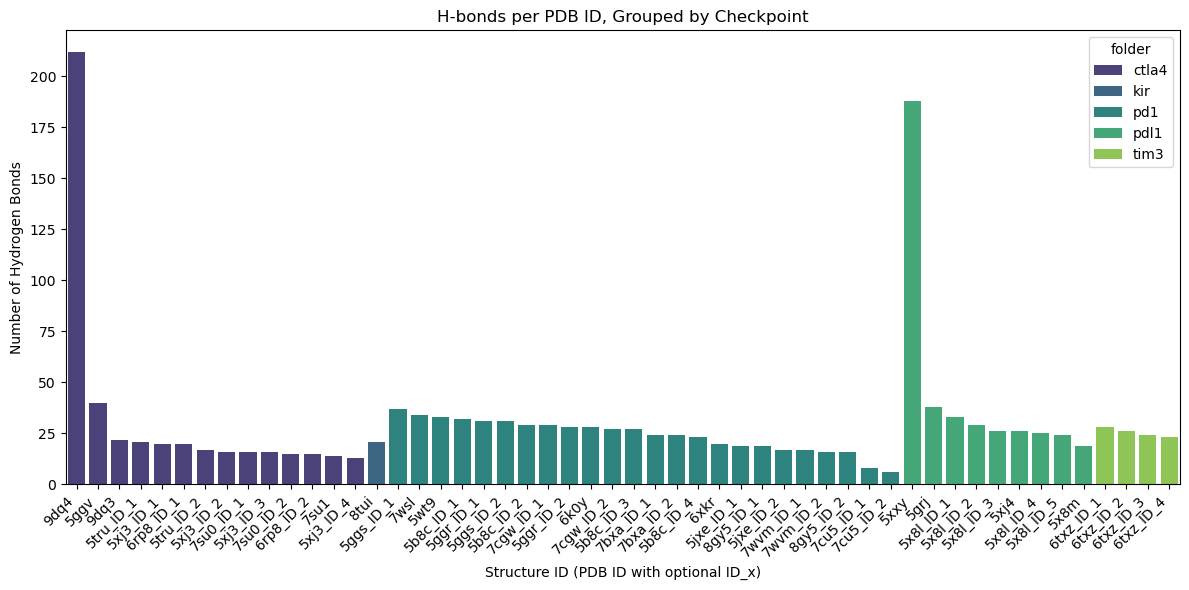

In [30]:
from collections import defaultdict, Counter 

# Sort as before
df_sorted = df.sort_values(by=["folder", "num_hydrogen_bonds"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted["structure_id"] = structure_ids

# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y="num_hydrogen_bonds", hue="folder", dodge=False, palette="viridis")

plt.title("H-bonds per PDB ID, Grouped by Checkpoint")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Hydrogen Bonds")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('plots/h_bonds_per_PDB.pdf', bbox_inches='tight')
plt.show()

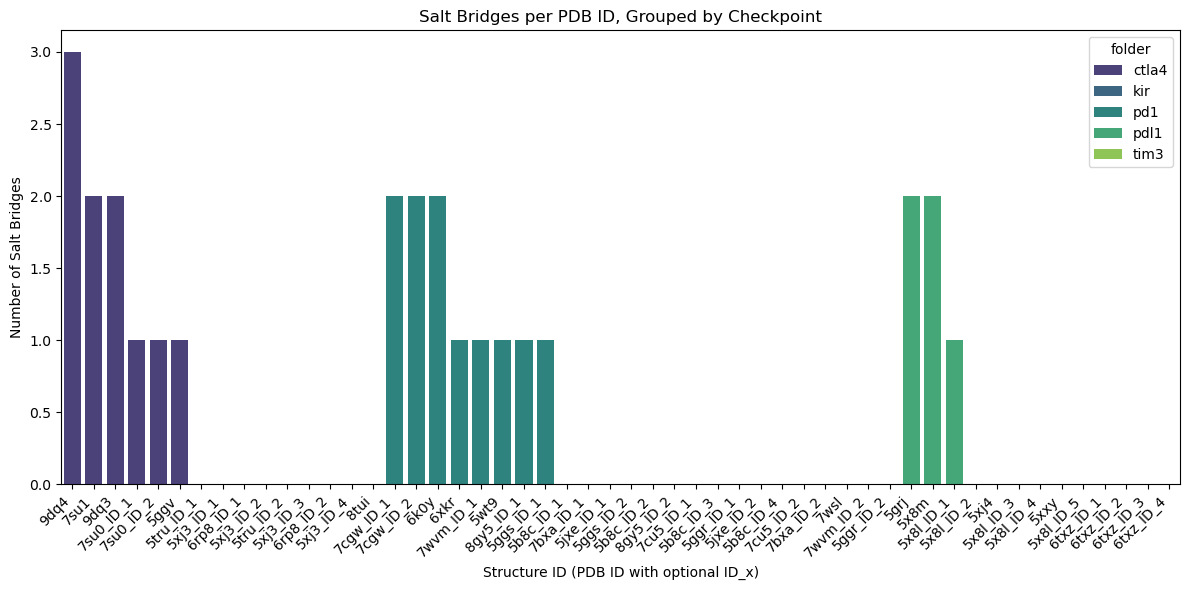

In [31]:
from collections import defaultdict, Counter

# Sort as before
df_sorted = df.sort_values(by=["folder", "num_salt_bridges"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted["structure_id"] = structure_ids


# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y="num_salt_bridges", hue="folder", dodge=False, palette="viridis")

plt.title("Salt Bridges per PDB ID, Grouped by Checkpoint")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Salt Bridges")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('plots/salt_bridges_per_PDB.pdf', bbox_inches='tight')
plt.show() 

# Binding Score 

In [32]:
from sklearn.preprocessing import MinMaxScaler

#normalizing
scaler = MinMaxScaler()
df = pd.read_csv("paratope_surface_hbonds_summary.csv")
features = df[["num_hydrogen_bonds", "num_salt_bridges", "paratope_area"]]
normalized = scaler.fit_transform(features)

df_norm = pd.DataFrame(normalized, columns=features.columns)
df_norm["pdb_id"] = df["pdb_id"]  

# Create a binding strength score
weights = {
    "num_hydrogen_bonds": 0.4,
    "num_salt_bridges": 0.4,
    "paratope_area": 0.2
}

df_norm["binding_score"] = (
    df_norm["num_hydrogen_bonds"] * weights["num_hydrogen_bonds"] +
    df_norm["num_salt_bridges"] * weights["num_salt_bridges"] +
    df_norm["paratope_area"] * weights["paratope_area"]
)

# Show top binders
print(df_norm.sort_values("binding_score", ascending=False)[["pdb_id", "binding_score"]])


   pdb_id  binding_score
5    9dq4       0.946239
33   5xxy       0.518688
24   7cgw       0.421995
15   7cgw       0.419402
41   5grj       0.417499
45   6k0y       0.405964
13   9dq3       0.397650
50   5x8m       0.363269
38   5ggs       0.360336
46   5ggv       0.344438
4    7su1       0.321967
21   5wt9       0.314146
6    6xkr       0.292989
27   5x8l       0.279508
18   5ggs       0.260194
37   8gy5       0.252315
42   7wsl       0.236411
34   7su0       0.234503
19   5b8c       0.229987
9    7wvm       0.223532
8    7su0       0.213487
26   5b8c       0.199163
2    5b8c       0.198566
30   5b8c       0.198451
49   5x8l       0.174748
0    6txz       0.166478
20   5x8l       0.161242
17   5x8l       0.160616
40   6txz       0.158448
35   6txz       0.147660
28   5ggr       0.144378
10   6txz       0.143712
3    5x8l       0.135432
29   5jxe       0.126071
14   5jxe       0.124032
7    5xj4       0.122888
32   8tui       0.121516
44   5ggr       0.104701
22   8gy5       0.103942


In [33]:
from collections import Counter, defaultdict

# Sort the dataframe
df_sorted = df_norm.sort_values(
    by=["binding_score", "num_hydrogen_bonds", "num_salt_bridges", "paratope_area"],
    ascending=[False, False, False, False]  # show top-scoring binders first
).copy()
# Count appearances
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build unique structure IDs
structure_ids = []
for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

# Add to DataFrame
df_sorted["structure_id"] = structure_ids

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/3630168040.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis")


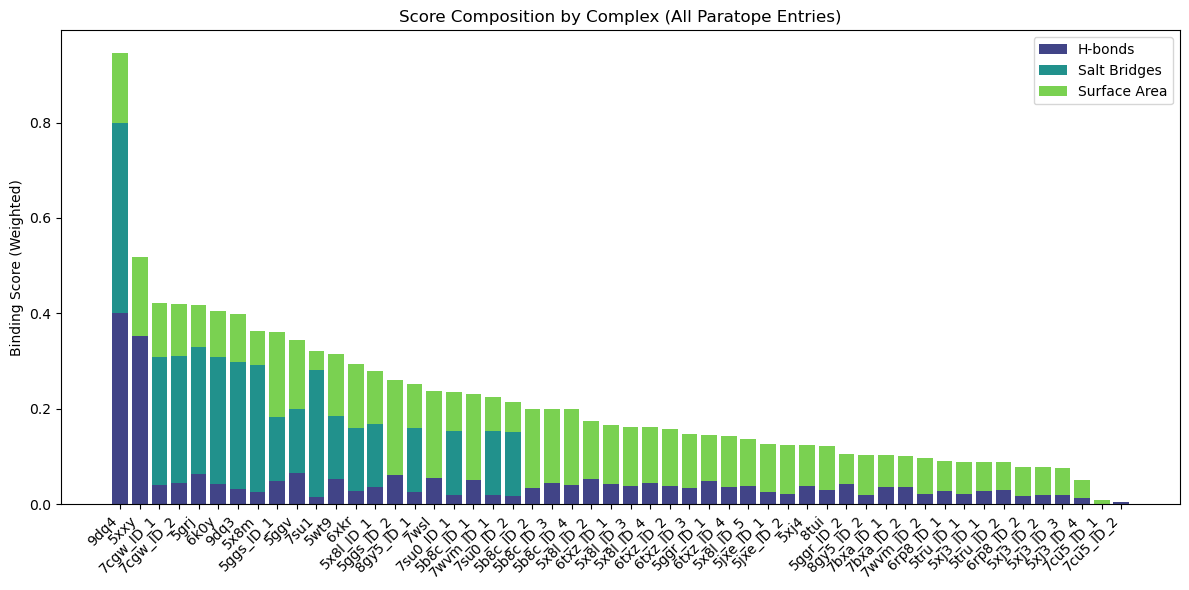

In [34]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Sort by binding score again
top = df_sorted.sort_values("binding_score", ascending=False)

# Use viridis colormap
viridis = cm.get_cmap("viridis")
colors = viridis(np.linspace(0.2, 0.8, 3))

plt.figure(figsize=(12, 6))

# Plot H-bonds
plt.bar(
    top["structure_id"],
    top["num_hydrogen_bonds"] * 0.4,
    label="H-bonds",
    color=colors[0],
    bottom=0
)

# Plot Salt Bridges
plt.bar(
    top["structure_id"],
    top["num_salt_bridges"] * 0.4,
    label="Salt Bridges",
    color=colors[1],
    bottom=top["num_hydrogen_bonds"] * 0.4
)

# Plot Surface Area
plt.bar(
    top["structure_id"],
    top["paratope_area"] * 0.2,
    label="Surface Area",
    color=colors[2],
    bottom=(top["num_hydrogen_bonds"] + top["num_salt_bridges"]) * 0.4
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Binding Score (Weighted)")
plt.title("Score Composition by Complex (All Paratope Entries)")
plt.legend()
plt.tight_layout()
plt.savefig("plots/paratope_binding_affinity_score.pdf", bbox_inches="tight")
plt.show()


# Sequences Paratope

In [35]:
# not unqiue sequences 
import os
from pymol import cmd
from Bio.SeqUtils import seq1
import pandas as pd
from collections import defaultdict, Counter

# Input settings
root_folder = "structures"
cutoff_distance = 5.0  # in Å
results = []

# Ensure extracted_list is defined
if 'extracted_list' not in locals():
    extracted_list = []  # Replace with actual data

# Loop through all extracted entries
for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue
    else:
        print(f"Processing {pdb_id}...")

    cmd.reinitialize()
    cmd.load(pdb_path)

    # Define selections
    cmd.select("antibody", f"chain {h_chain}+{l_chain}")
    cmd.select("antigen", f"chain {ag_chain}")
    cmd.select("paratope", f"antibody within {cutoff_distance} of antigen")

    # Extract unique residues from epitope
    model = cmd.get_model("paratope")
    seen = set()
    residues = []
    for atom in model.atom:
        res_id = (atom.chain, atom.resi)
        if res_id not in seen:
            seen.add(res_id)
            residues.append(atom.resn)

    sequence = ''.join(seq1(res) for res in residues if res != "HOH")

    # Collect results
    results.append({
        "pdb_id": pdb_id,
        "H_chain": h_chain,
        "L_chain": l_chain,
        "antigen_chain": ag_chain,
        "paratope_sequence": sequence,
        "folder": os.path.basename(dirpath)
    })

# Convert to DataFrame
df_seq = pd.DataFrame(results)

# Assign unique structure_id like in other analyses
df_seq = df_seq.sort_values(by=["folder", "paratope_sequence"], ascending=[True, False]).copy()
id_frequencies = Counter(df_seq["pdb_id"])
id_tracker = defaultdict(int)

structure_ids = []
for pdb_id in df_seq["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_seq["structure_id"] = structure_ids

# Save CSV
df_seq.to_csv("paratope_sequences_summary.csv", index=False)
print("Summary table saved to 'paratope_sequences_summary.csv'")

# Save FASTA
with open("paratope_sequences.fasta", "w") as f:
    for _, row in df_seq.iterrows():
        f.write(f">{row['structure_id']}\n{row['paratope_sequence']}\n")

print("FASTA file saved to 'paratope_sequences.fasta'")

# Add sequence to df_sorted

df_sorted = df_seq.sort_values(by=["folder", "paratope_sequence"], ascending=[True, False]).copy()
   


Processing 6txz...
Processing 5tru...
Processing 5b8c...
Processing 5x8l...
Processing 7su1...
Processing 9dq4...
Processing 6xkr...
Processing 5xj4...
Processing 7su0...
Processing 7wvm...
Processing 6txz...
Processing 5xj3...
Processing 7bxa...
Processing 9dq3...
Processing 5jxe...
Processing 7cgw...
Processing 6rp8...
Processing 5x8l...
Processing 5ggs...
Processing 5b8c...
Processing 5x8l...
Processing 5wt9...
Processing 8gy5...
Processing 5xj3...
Processing 7cgw...
Processing 7cu5...
Processing 5b8c...
Processing 5x8l...
Processing 5ggr...
Processing 5jxe...
Processing 5b8c...
Processing 7cu5...
Processing 8tui...
Processing 5xxy...
Processing 7su0...
Processing 6txz...
Processing 7bxa...
Processing 8gy5...
Processing 5ggs...
Processing 5tru...
Processing 6txz...
Processing 5grj...
Processing 7wsl...
Processing 7wvm...
Processing 5ggr...
Processing 6k0y...
Processing 5ggv...
Processing 5xj3...
Processing 6rp8...
Processing 5x8l...
Processing 5x8m...
Processing 5xj3...
Summary tabl

In [36]:
print(df_sorted)

   pdb_id H_chain L_chain antigen_chain  \
46   5ggv       H       L             Y   
16   6rp8       h       l             c   
48   6rp8       H       L             C   
1    5tru       h       l             c   
23   5xj3       A       B             C   
47   5xj3       J       K             L   
51   5xj3       G       H             I   
11   5xj3       D       E             F   
39   5tru       H       L             C   
13   9dq3       H       L             C   
5    9dq4       H       L             A   
8    7su0       H       L             C   
34   7su0       I       M             D   
4    7su1       H       L             C   
32   8tui       H       L             A   
15   7cgw       H       L             P   
42   7wsl       H       L             D   
38   5ggs       C       D             Y   
18   5ggs       A       B             Z   
29   5jxe       G       F             A   
2    5b8c       K       J             L   
26   5b8c       H       G             I   
14   5jxe  

## Identiy Matrix

In [37]:
from Bio import SeqIO # to read sequences from a FASTA file
from Bio import pairwise2 # pairwise sequence alignments
import pandas as pd

# Load your sequences
records = list(SeqIO.parse("paratope_sequences.fasta", "fasta"))

# Initialize identity matrix
matrix = []

# Compare each pair
for r1 in records:
    row = []
    for r2 in records:
        alignments = pairwise2.align.globalxx(r1.seq, r2.seq) # Align two sequences (whole sequence)
        best = alignments[0]
        identity = best.score / max(len(r1.seq), len(r2.seq)) * 100  # identiy in % -> (number of matches) / (length of longer sequence) × 100
        row.append(round(identity, 2))
    matrix.append(row)

# Create a DataFrame
ids = [rec.id for rec in records]
df = pd.DataFrame(matrix, index=ids, columns=ids)

# Save & show
df.to_csv("paratope_sequence_comparison_matrix.csv")
print(" Sequence identity matrix saved to 'paratope_sequence_comparison_matrix.csv'")
print(df)


/opt/anaconda3/envs/pymol-env/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


 Sequence identity matrix saved to 'paratope_sequence_comparison_matrix.csv'
             5ggv  6rp8_ID_1  6rp8_ID_2  5tru_ID_1  5xj3_ID_1  5xj3_ID_2  \
5ggv       100.00      35.71      32.14      35.71      39.29      39.29   
6rp8_ID_1   35.71     100.00      95.00      90.91      90.48      81.82   
6rp8_ID_2   32.14      95.00     100.00      90.91      85.71      81.82   
5tru_ID_1   35.71      90.91      90.91     100.00      86.36      86.36   
5xj3_ID_1   39.29      90.48      85.71      86.36     100.00      90.91   
5xj3_ID_2   39.29      81.82      81.82      86.36      90.91     100.00   
5xj3_ID_3   32.14      85.00      85.00      77.27      85.71      81.82   
5xj3_ID_4   42.86      86.96      82.61      86.96      91.30      91.30   
5tru_ID_2   39.29      90.48      85.71      90.91      85.71      86.36   
9dq3        39.29      52.00      52.00      56.00      56.00      60.00   
9dq4        39.29      48.15      48.15      51.85      51.85      55.56   
7su0_ID_1  

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/416771499.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = df.applymap(lambda x: f"{x:.0f}")


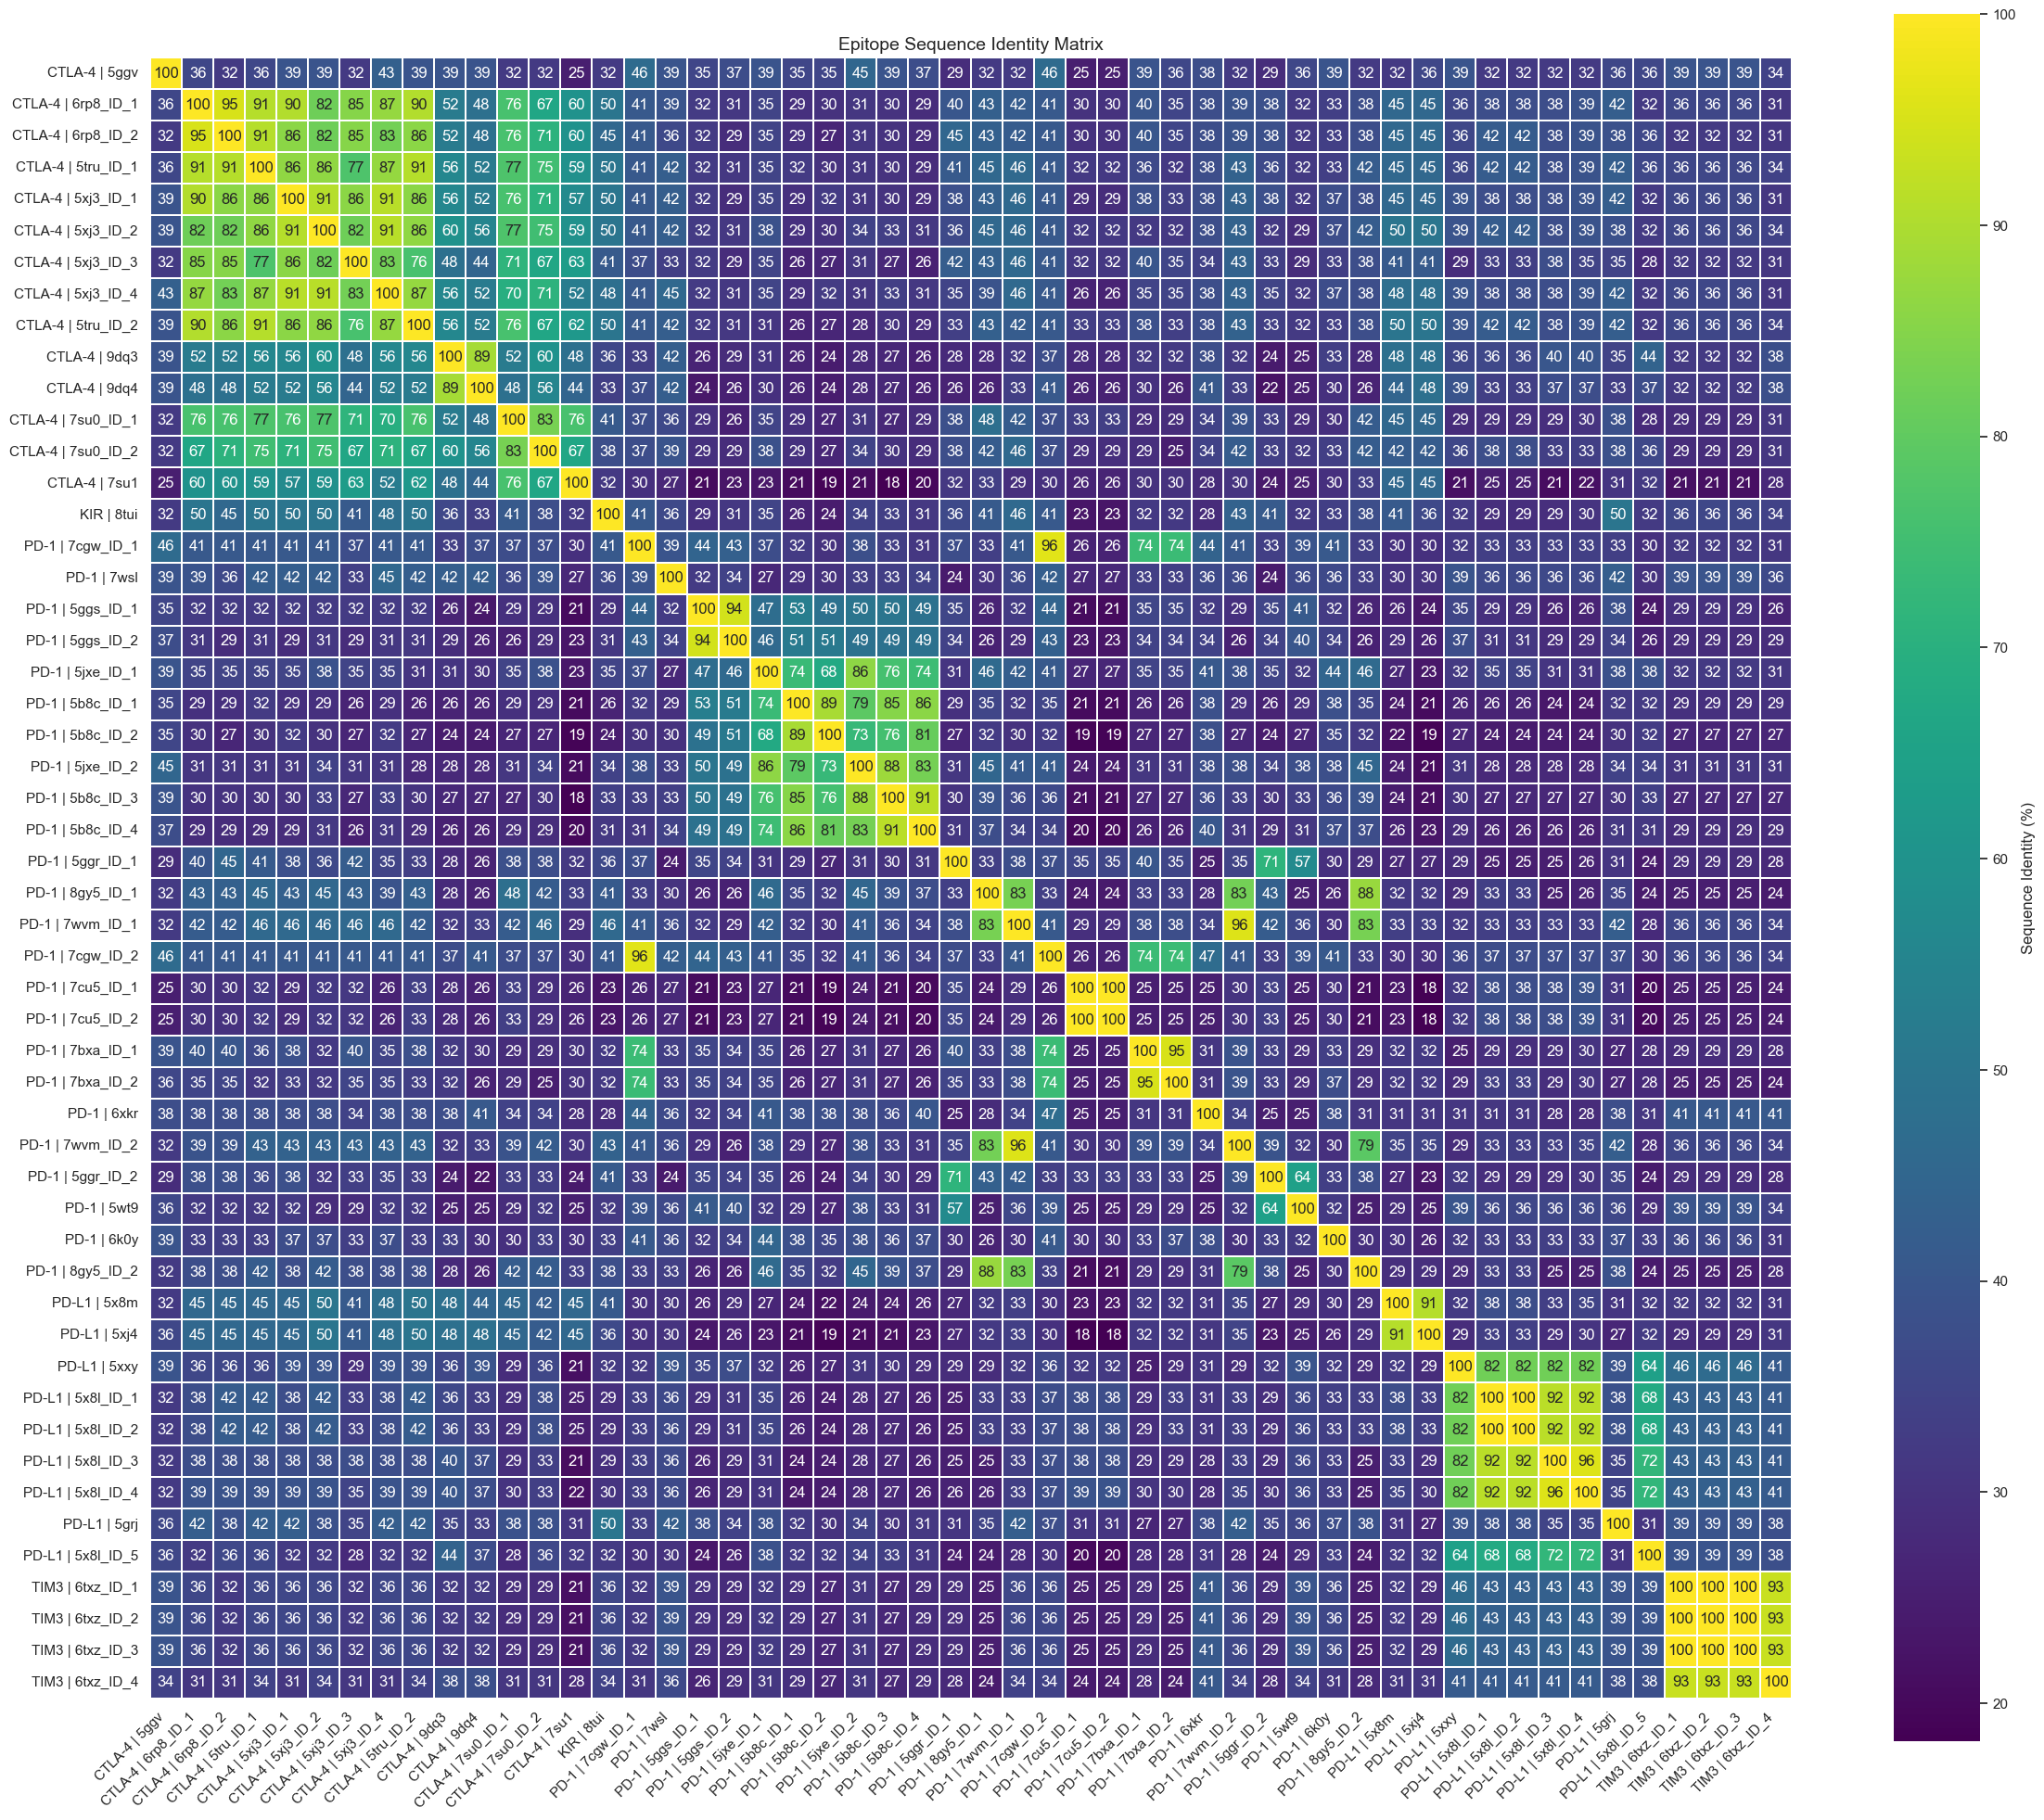

Cleaned-up heatmap saved as 'paratope_identity_heatmap_final.png'


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from collections import defaultdict, Counter

checkpoints = ['PD-1', 'PD-L1', 'CTLA-4', 'KIR', 'LAG3', 'TIM3']

pdb_ids = {
    'PD-1': pd1['pdb'].unique().tolist(), # mit variable funktioniert unique nicht
    'PD-L1': pdl1['pdb'].unique().tolist(),
    'CTLA-4': ctla4['pdb'].unique().tolist(),
    'KIR': kir['pdb'].unique().tolist(),
    'LAG3': lag3['pdb'].unique().tolist(),
    'TIM3': tim3['pdb'].unique().tolist(),
}

# Create mapping from PDB ID → Checkpoint
pdb_to_checkpoint = {}
for checkpoint, pdb_list in pdb_ids.items():
    for pdb in pdb_list:
        pdb_to_checkpoint[pdb.lower()] = checkpoint

# Update row and column labels using base PDB ID
def get_checkpoint_label(pdb_id):
    base_id = pdb_id.lower().split('_')[0]  # e.g. "5x8l_ID_1" → "5x8l"
    checkpoint = pdb_to_checkpoint[base_id]
    return f"{checkpoint} | {pdb_id}"

df = df.copy()
df.index = [get_checkpoint_label(p) for p in df.index]
df.columns = [get_checkpoint_label(p) for p in df.columns]



annot_data = df.applymap(lambda x: f"{x:.0f}")
mask = None

plt.figure(figsize=(24, 20))
sns.set(style="white", font_scale=1.0)
# annot_data = df.applymap(lambda x: f"{int(x)}" if x >= 70 else "")


ax = sns.heatmap(
    df, 
    annot=annot_data, 
    fmt="", 
    cmap="viridis", 
    mask=mask,
    square=True, 
    linewidths=0.3, 
    cbar_kws={"label": "Sequence Identity (%)"}
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Epitope Sequence Identity Matrix", fontsize=14)
plt.tight_layout()

plt.savefig("paratope_identity_heatmap_final.png", dpi=300)
plt.show()

print("Cleaned-up heatmap saved as 'paratope_identity_heatmap_final.png'")

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2760505932.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = df.applymap(lambda x: f"{int(x)}" if x >= 70 else "")


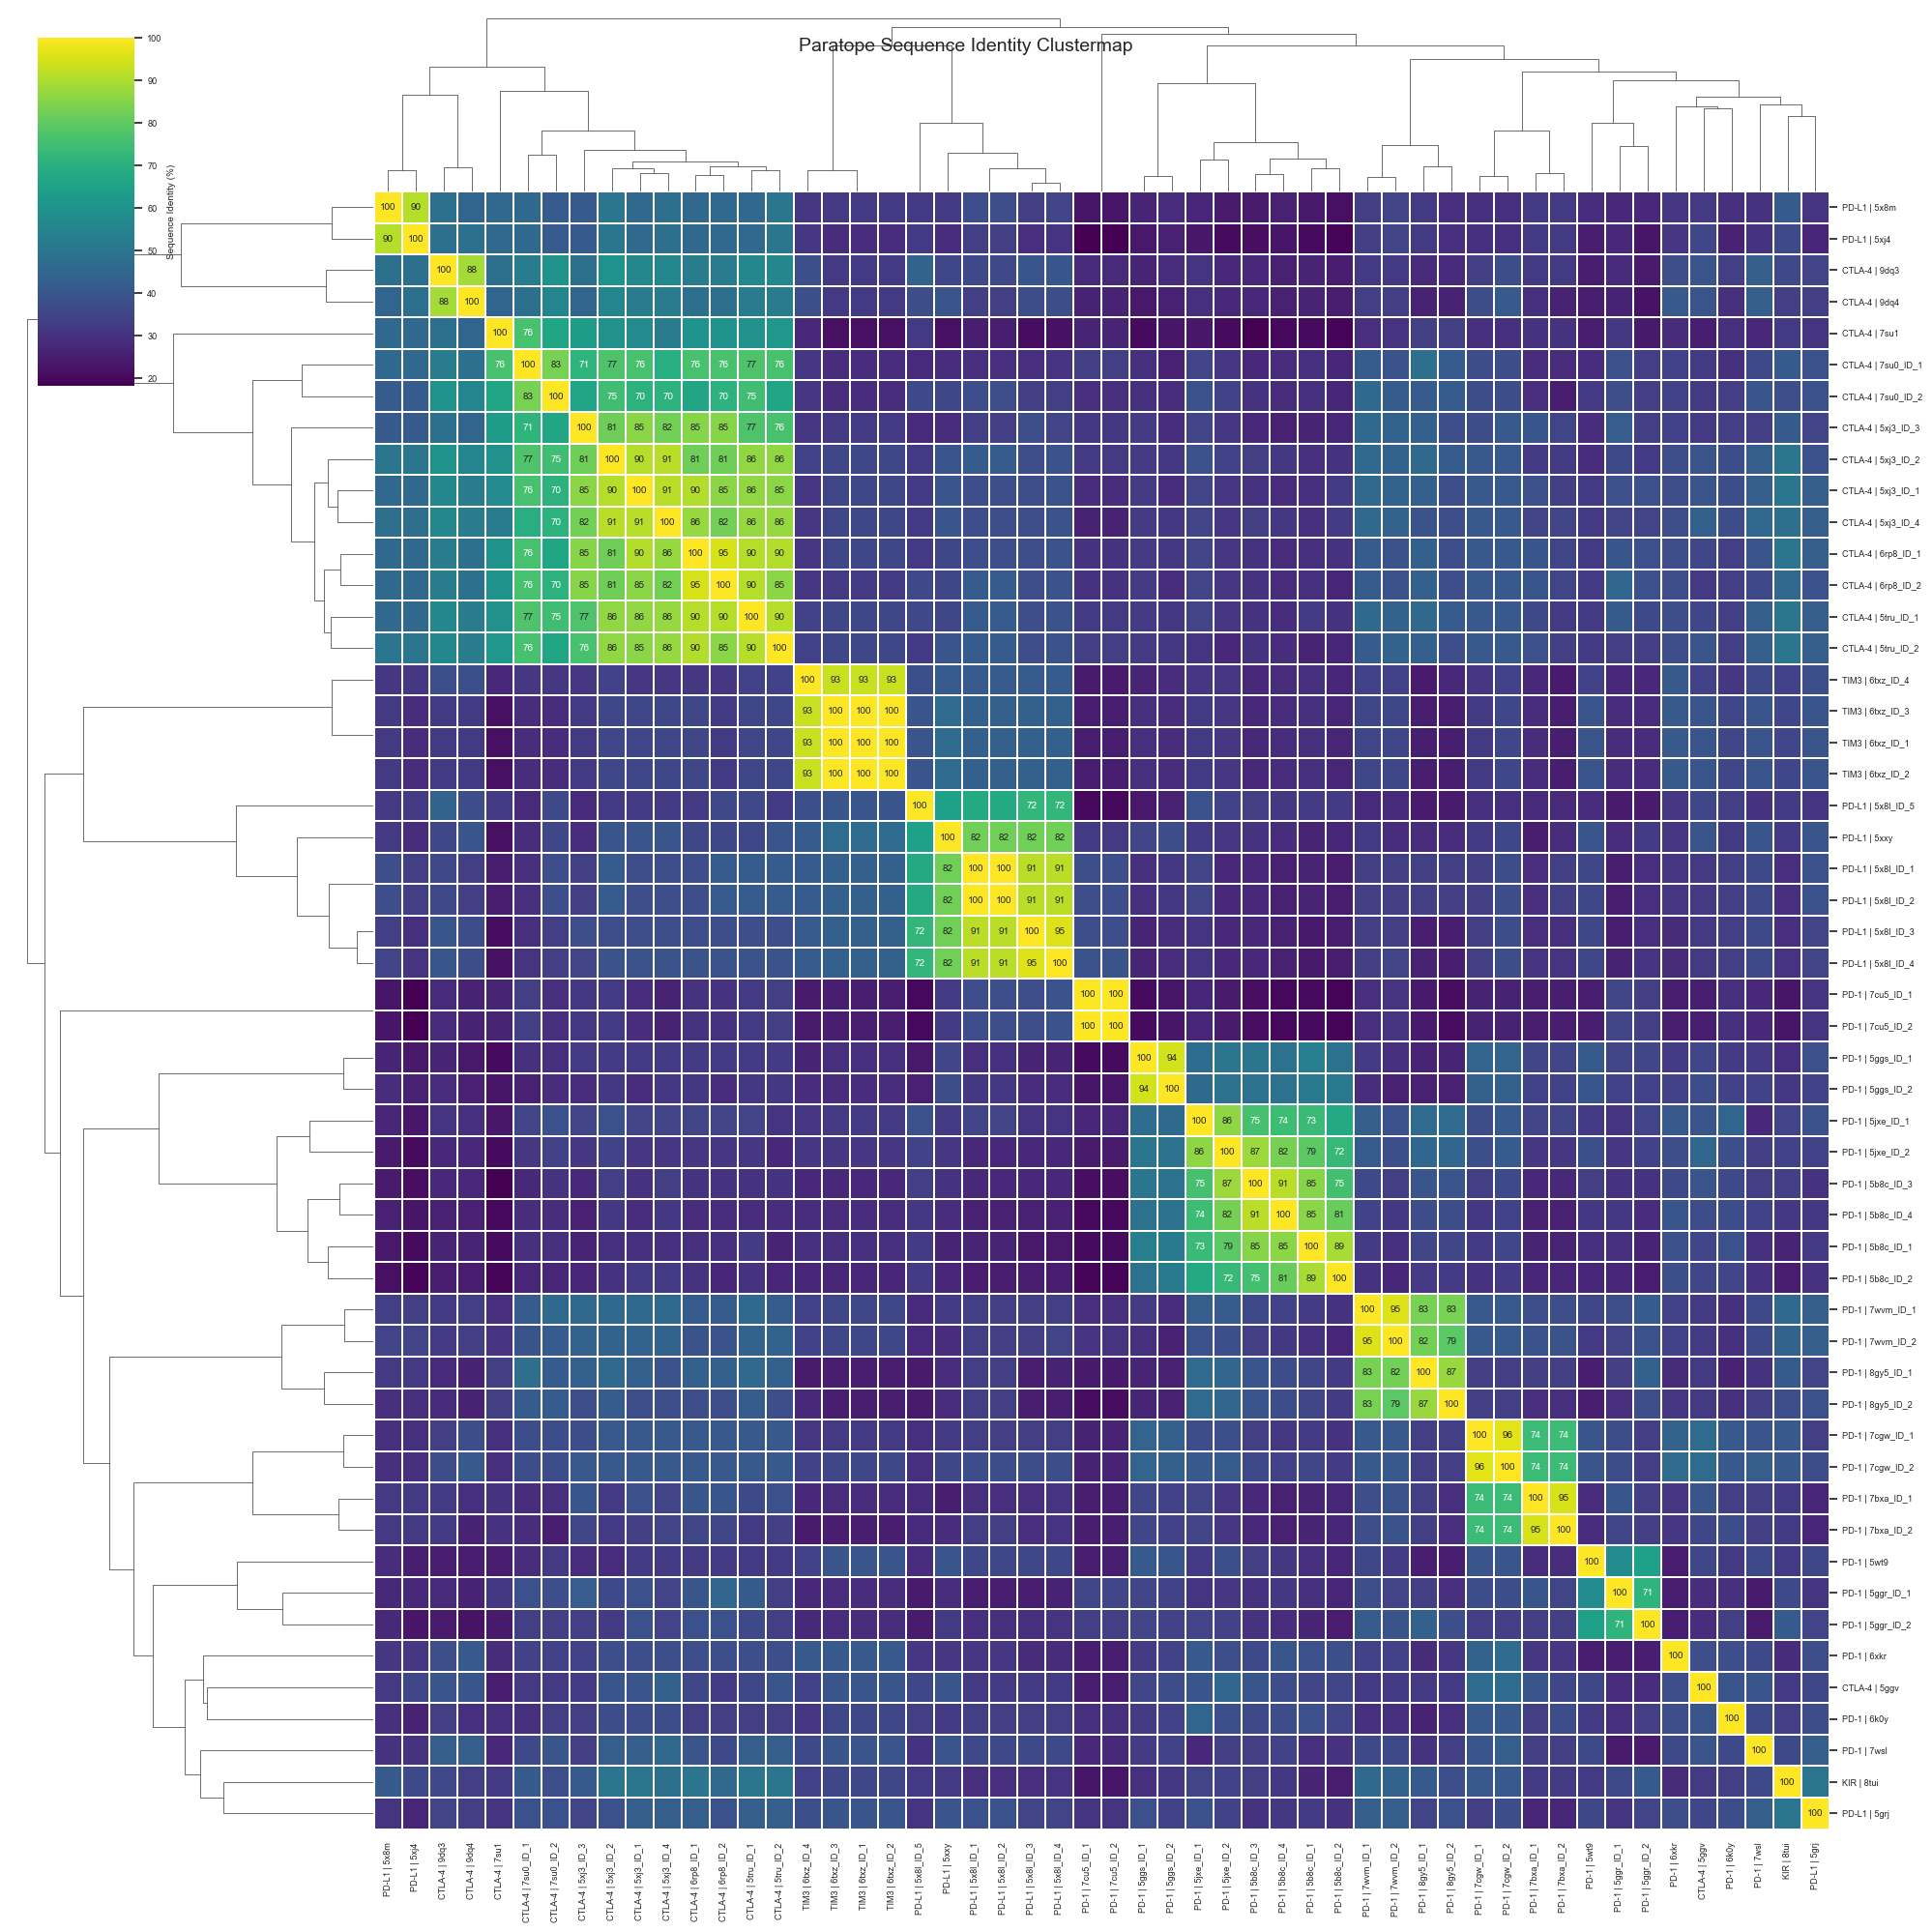

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: annotate only high identities
annot_data = df.applymap(lambda x: f"{int(x)}" if x >= 70 else "")

# Seaborn clustermap
sns.set(font_scale=0.6)  # smaller font for big matrices
g = sns.clustermap(
    df,
    cmap="viridis",
    figsize=(20, 20),
    annot=annot_data,
    fmt="",
    linewidths=0.3,
    cbar_kws={"label": "Sequence Identity (%)"},
    dendrogram_ratio=(.2, .1),  # ratio for row/col dendrograms
    xticklabels=True,
    yticklabels=True
)



# Optional: save as high-res PDF
g.fig.suptitle("Paratope Sequence Identity Clustermap", fontsize=14)
plt.savefig("paratope_clustermap.pdf", dpi=300, bbox_inches="tight")
plt.show()


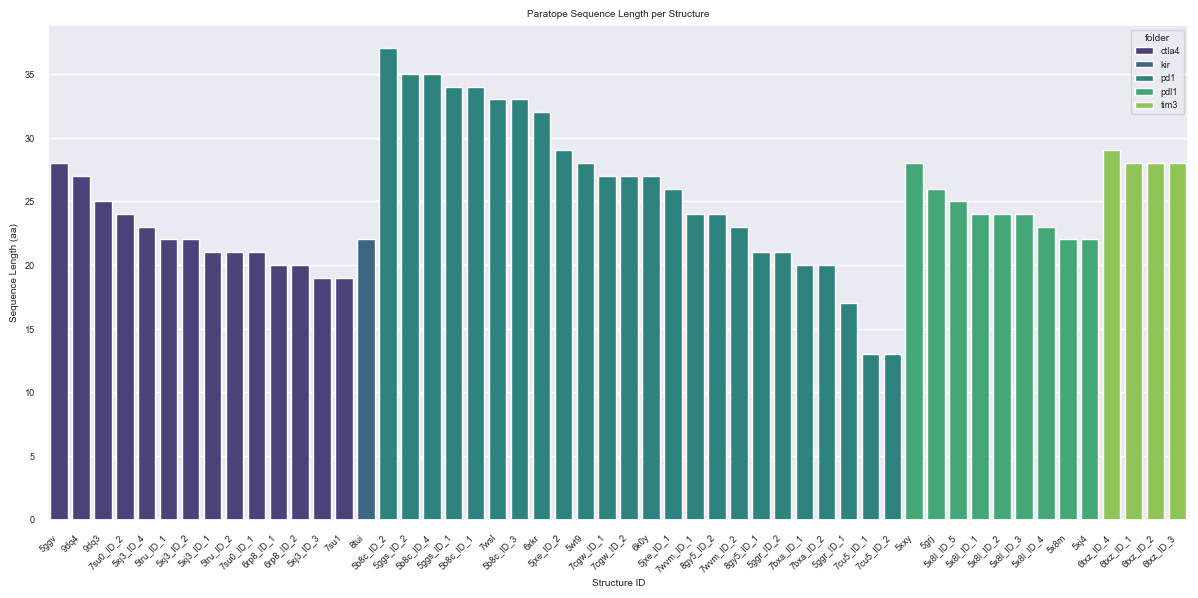

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add a column with the sequence length
df_seq["paratope_length"] = df_seq["paratope_sequence"].str.len()

# Sort for better visualization (optional)
df_seq_sorted = df_seq.sort_values(by=["folder", "paratope_length"], ascending=[True, False])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_seq_sorted, x="structure_id", y="paratope_length", hue="folder", dodge=False, palette="viridis")

plt.title("Paratope Sequence Length per Structure")
plt.xlabel("Structure ID")
plt.ylabel("Sequence Length (aa)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("paratope_sequence_lengths.pdf", bbox_inches='tight')
plt.show()
